In [66]:
import os
import polars as pl
import pandas as pd
import numpy as np
from functools import partial
import dproc, sgutil

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data_path = 'data'
if not os.path.isdir(data_path):
    os.mkdir(data_path)
files = {
    k: os.path.join(p, f)
    for k, p, f in [
        ('train', data_path, 'train.csv'),
        ('test', data_path, 'test.csv'),
        ('org_train', data_path, 'train_org.csv'),
        ('org_test', data_path, 'test_org.csv'),
        ('train_parquet', data_path, 'train.parquet'),
        ('org_pkl', data_path, 'org.pkl'),
        ('test_parquet', data_path, 'test.parquet'),
        ('var_pkl', data_path, 'var.pkl')
    ]
}

if (not os.path.isfile(files['train'])) and (not os.path.isfile(files['var_pkl'])):
    !kaggle competitions download -c playground-series-s4e7
    !mkdir data
    !unzip playground-series-s4e7.zip -d data
    !rm playground-series-s4e7.zip
    !kaggle datasets download -d annantkumarsingh/health-insurance-cross-sell-prediction-data
    !unzip health-insurance-cross-sell-prediction-data.zip
    !mv train.csv data/train_org.csv
    !mv test.csv data/test_org.csv
    !rm health-insurance-cross-sell-prediction-data.zip

In [3]:
if not os.path.exists(files['var_pkl']):
    from io import StringIO
    vars = StringIO(
    """Age	(continous)	Age of the Customer.
    Gender	(dichotomous)	Gender of the Customer.
    Driving_License	(dichotomous)	0 for customer not having DL, 1 for customer having DL.
    Region_Code	(nominal)	Unique code for the region of the customer.
    Previously_Insured	(dichotomous)	0 for customer not having vehicle insurance, 1 for customer having vehicle insurance.
    Vehicle_Age	(nominal)	Age of the vehicle.
    Vehicle_Damage	(dichotomous)	Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past.
    Annual_Premium	(continous)	The amount customer needs to pay as premium in the year.
    Policy_Sales_Channel	(nominal)	Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.
    Vintage	(continous)	Number of Days, Customer has been associated with the company.
    Response (Dependent Feature)	(dichotomous)	1 for Customer is interested, 0 for Customer is not interested."""
    )
    df_var = pd.read_csv(vars, sep='\t', header=None).rename(
        columns={0: 'name', 1: 'type', 2: 'Description'}
    )
    df_var.head()
    df_type = dproc.merge_type_df([
        pl.scan_csv(files[i]).pipe(dproc.get_type_df) for i in ['train', 'test', 'org_train', 'org_test']
    ])
    # Region_Code to category, Policy_Sales_Channel to category
    pl_type = dproc.get_type_pl(df_type, {'Region_Code': pl.Categorical, 'Policy_Sales_Channel': pl.Categorical, 'Previously_Insured': pl.Categorical})
    s_type = pd.Series(pl_type).astype(str).rename('dtype')
    df_var = df_var.set_index('name').rename(columns={'type': 'var_type'}).join(df_type.drop(columns='dtype')).join(s_type)
    pl.scan_csv('data/train.csv', schema_overrides = pl_type).sink_parquet(files['train_parquet'])
    pl.scan_csv('data/test.csv', schema_overrides = pl_type).sink_parquet(files['test_parquet'])
    df_var.to_pickle(files['var_pkl'])
    !rm data/train.csv
    !rm data/test.csv
sc = sgutil.SGCache('img', 'result')
df_var = pd.read_pickle(files['var_pkl']).assign(src="org").set_index('name')
df_var

,type,Description,src
name,,,
Age,(continous),Age of the Customer.,org
Gender,(dichotomous),Gender of the Customer.,org
Driving_License,(dichotomous),"0 for customer not having DL, 1 for customer h...",org
Region_Code,(nominal),Unique code for the region of the customer.,org
Previously_Insured,(dichotomous),"0 for customer not having vehicle insurance, 1...",org
Vehicle_Age,(nominal),Age of the vehicle.,org
Vehicle_Damage,(dichotomous),Customer got his/her vehicle damaged in the pa...,org
Annual_Premium,(continous),The amount customer needs to pay as premium in...,org
Policy_Sales_Channel,(nominal),Anonymized Code for the channel of outreaching...,org


# Polars Processing

In [4]:
dprocs = list()
df_train = pl.read_parquet(files['train_parquet'])
df_test = pl.read_parquet(files['test_parquet'])

mode_AnnualPremium = df_train['Annual_Premium'].mode()[0]
mean_Annual_Premium_without_mode = df_train.filter(pl.col('Annual_Premium') != mode_AnnualPremium)['Annual_Premium'].mean()
proc_list=[
    ('is_Annual_Premium_mode', pl.when(pl.col('Annual_Premium') == mode_AnnualPremium).then(1).otherwise(0).cast(pl.Int8), 'Annual_Premium의 최빈값 여부'),
]

In [5]:
df_train, df_var = dproc.apply_with_columns(df_train, dprocs, 'mode')
df_train = df_train.to_pandas().set_index('id')
df_test = dproc.apply_with_columns(df_test, dprocs)
df_test = df_test.to_pandas().set_index('id')
target = 'Response'

In [6]:
pd_procs = dproc.PD_Vars.load_or_create(os.path.join('data', 'vars') , df_var)

# Categorical Data Processing

In [7]:
sc.cache_result('cat_vals_not_in_train',
    lambda : pd.concat([
        df_train[['Policy_Sales_Channel', 'Region_Code', 'Vintage']].apply(set, axis=0, raw=True).rename('train'),
        df_test[['Policy_Sales_Channel', 'Region_Code', 'Vintage']].apply(set, axis=0, raw=True).rename('test')
    ], axis=1).apply(
        lambda x: x['test'] - x['train'], axis=1
    )
)

Policy_Sales_Channel    {144.0, 149.0}
Region_Code                         {}
Vintage                             {}
dtype: object

In [176]:
def repl_nearest(cat_vals, x):
    return np.argmin(np.abs(cat_vals - x))

def get_nearest_c_proc(df, col, min_cnt = 5):
    s_cat_count = df[col].value_counts().pipe(lambda x: x.loc[x >= min_cnt])
    repl = df[col].value_counts().pipe(lambda x: x.loc[x < min_cnt]).index
    cat_vals = s_cat_count.sort_index().index
    cat_c_type = pd.CategoricalDtype(cat_vals, ordered=True)
    return lambda x: dproc.replace_cat(
        dproc.rearrange_cat(
            x[col].astype('category'), cat_c_type, repl_nearest
        ), lambda y: str(y)
    ).rename('{}_S'.format(col))

def get_categ_proc(df):
    region_c_type = pd.CategoricalDtype(dproc.replace_cat(df['Region_Code'], {'39.2': '39.0'}).unique())
    s_cnt = df['Policy_Sales_Channel'].value_counts().pipe(lambda x: x.loc[x > 10])
    policy_sales_channel_c_type = pd.CategoricalDtype(['etc'] + s_cnt.index.tolist())
    return lambda x: pd.concat([
        dproc.replace_cat(x['Region_Code'], {'39.2': '39.0'}).astype(region_c_type).rename('Region_Code_S'),
        dproc.rearrange_cat(x['Policy_Sales_Channel'], policy_sales_channel_c_type, lambda c, v: 0 if v not in c else v).rename('Policy_Sales_Channel_S'),
    ], axis=1)

cat_proc_list = sc.cache_result(
    'cat_proc_list',
    lambda : [
        (get_nearest_c_proc(df_train, 'Annual_Premium'), "Annual_Premium의 범주형 변수"),
        (get_nearest_c_proc(df_train, 'Vintage'), "Vintage의 범주형 변수"),
        (get_nearest_c_proc(df_train, 'Age'), "Age의 범주형 변수"),
        (get_categ_proc(df_train), {'Region_Code_S': 'Region_Code를 범주형 변수', 'Policy_Sales_Channel_S': 'Policy_Sales_Channel의 범주형 변수'})
    ]
)
df_train = pd_procs.put_proc('cat_proc', df_train, cat_proc_list)

In [177]:
pd_procs.save()

# Categorical Data

In [180]:
from scipy.stats import chi2_contingency

s_chi2_result = sc.cache_result(
    'chi2_test',
    lambda : df_train[['Vehicle_Age', 'Vehicle_Damage', 'Region_Code_S', 'Policy_Sales_Channel_S', 'Vintage_S', 'Annual_Premium_S', 'Age_S', 
                       'Previously_Insured', 'Driving_License', 'Gender']].apply(
        lambda x: chi2_contingency(
            pd.crosstab(index=x, columns=df_train[target])
        )[0]
    )
)
s_chi2_result.sort_values(ascending=False).rename('Chi2-statistic').to_frame().T

,Vehicle_Damage,Previously_Insured,Policy_Sales_Channel_S,Annual_Premium_S,Age_S,Vehicle_Age,Vintage_S,Region_Code_S,Gender,Driving_License
Chi2-statistic,1.489196e+06,1.376748e+06,849212.934678,848216.028935,701977.770434,614768.206138,327749.404281,260136.125714,35070.871592,972.499672


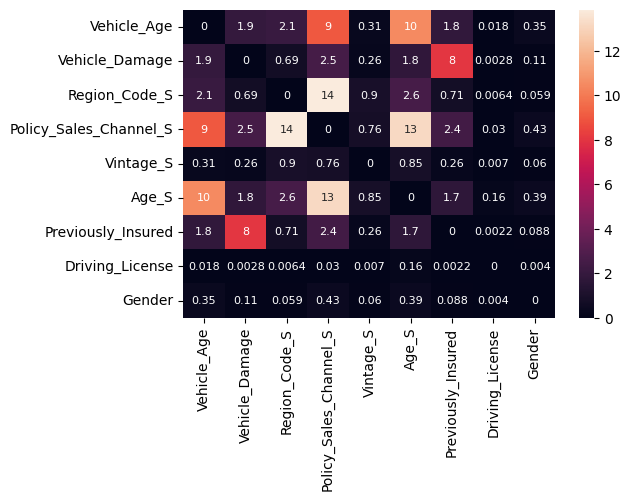

In [181]:
from scipy.spatial.distance import pdist, squareform
pair_chi2 = ['Vehicle_Age', 'Vehicle_Damage', 'Region_Code_S', 'Policy_Sales_Channel_S', 'Vintage_S', 'Age_S', 'Previously_Insured', 'Driving_License', 'Gender']
df_chi2_pair = sc.cache_result(
    'chi2_pairs',
    lambda : pdist(
        df_train[pair_chi2].T, 
        lambda u, v: chi2_contingency(pd.crosstab(index=u, columns=v))[0]
    )
)
plt.figure(figsize=(6, 4))
sns.heatmap(
    pd.DataFrame(squareform(df_chi2_pair), index=pair_chi2,columns=pair_chi2) / 1e6, annot=True, annot_kws={'fontsize': 8}
)
plt.show()

In [182]:
s_chi2_annual = sc.cache_result(
    'chi2_annual',
    lambda : df_train[pair_chi2].apply(
        lambda x: chi2_contingency(
            pd.crosstab(index=x, columns=df_train[target])
        ), axis=0
    )
).apply(lambda x: x[0]) / 1e6
s_chi2_annual.to_frame().T

,Vehicle_Age,Vehicle_Damage,Region_Code_S,Policy_Sales_Channel_S,Vintage_S,Age_S,Previously_Insured,Driving_License,Gender
0,0.614768,1.489196,0.260136,0.000013,0.327749,0.701978,1.376748,0.000972,0.035071


In [183]:
pd.concat([
    df_train.groupby(['Vehicle_Damage',  'Previously_Insured'], observed=True)[target].size().rename('count'),
    df_train.groupby(['Vehicle_Damage',  'Previously_Insured'], observed=True)[target].sum().rename('sum'),
    df_train.groupby(['Vehicle_Damage',  'Previously_Insured'], observed=True)[target].mean().rename('ratio'),
], axis=1)

count      sum     ratio
Vehicle_Damage Previously_Insured                            
Yes            0                   5504102  1389217  0.252397
               1                    279127     1821  0.006524
No             0                    674014    22442  0.033296
               1                   5047555     1579  0.000313

# Continuous Data

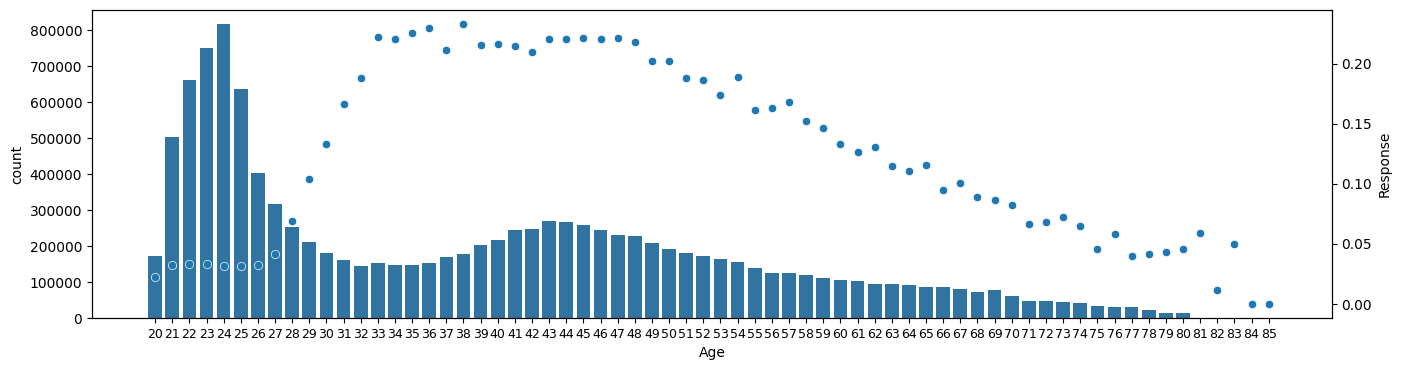

In [184]:
plt.figure(figsize=(16, 4))
sns.barplot(df_train['Age'].value_counts())
plt.gca().tick_params(axis='x', which='major', labelsize=9)
sns.scatterplot(df_train.groupby('Age')[target].mean().reset_index(drop=True), ax=plt.gca().twinx())
plt.show()

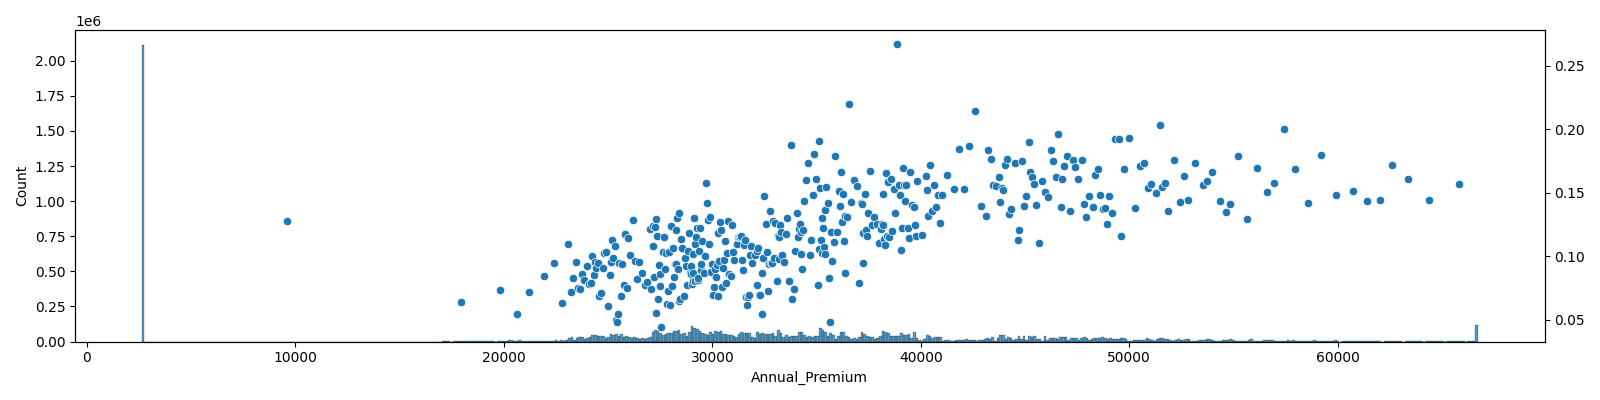

In [185]:
def show_annual_premium(ax):
    s_clip = df_train['Annual_Premium'].clip(0, df_train['Annual_Premium'].quantile(0.99))
    sns.histplot(s_clip, ax=ax)
    df_train.groupby(pd.qcut(s_clip, 500, duplicates='drop'), observed=True)[target].mean().pipe(
        lambda x: sns.scatterplot(x = x.index.map(lambda x: (x.left + x.right) * 0.5), y = x.values, ax=ax.twinx())
    )
sc.cache_fig('annual_premium_fig', lambda x: show_annual_premium(x), 1, 1, figsize=(16, 4))

In [186]:
from scipy.stats import spearmanr
from scipy.stats import mannwhitneyu

s_annual_premium = sc.cache_result(
    'annual_premium_stat',
    lambda : pd.Series([
        df_train.groupby(pd.qcut(df_train['Annual_Premium'], 500, duplicates='drop'), observed=True)[target].mean().pipe(
            lambda x: spearmanr(x.index.map(lambda x: (x.left + x.right) * 0.5), x.values)
        ),
        mannwhitneyu(*df_train.groupby(target)['Annual_Premium'].agg(list))[0],
    ], index=['spearman_corr_with_prob', 'manwhitneyu-stat-Annual_Premium'])
)
s_annual_premium.to_frame().T

,spearman_corr_with_prob,manwhitneyu-stat-Annual_Premium
0,"(0.7670440553823056, 1.846609403877403e-80)",6520667707045.0


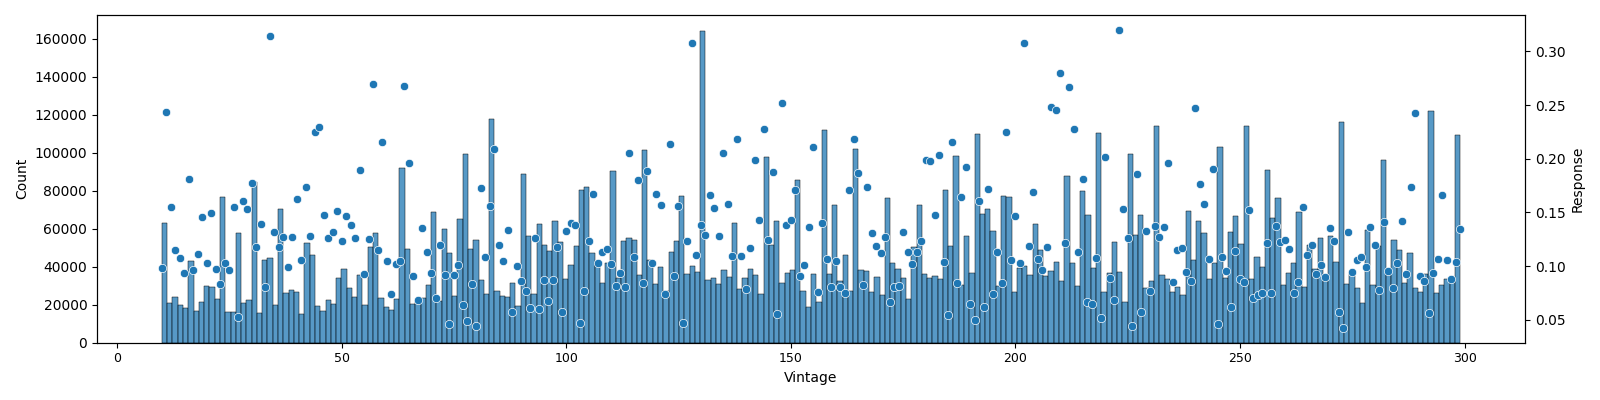

In [187]:
def show_vintage(ax):
    sns.histplot(df_train['Vintage'], ax=ax)
    ax.tick_params(axis='x', which='major', labelsize=9)
    sns.scatterplot(df_train.groupby('Vintage')[target].mean(), ax=ax.twinx())
sc.cache_fig(
    'vintage_fig', show_vintage, 1, 1, (16, 4)
)         

In [188]:
s_vintage = sc.cache_result(
    'vintage_stat',
    lambda : pd.Series([
        df_train.groupby('Vintage', observed=True)[target].mean().pipe(
            lambda x: spearmanr(x.index, x.values)
        ),
        mannwhitneyu(*df_train.groupby(target)['Vintage'].agg(list))[0],
    ], index=['spearman_corr_with_prob', 'manwhitneyu-stat'])
)
s_vintage.to_frame().T

,spearman_corr_with_prob,manwhitneyu-stat
0,"(-0.09089853460884155, 0.12247699537889553)",7326595875460.0


In [189]:
df_train.groupby(target)['Vintage'].median()

Response
0    167.0
1    164.0
Name: Vintage, dtype: float64

# Analysis through ML Models

In [190]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import TargetEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

import lightgbm as lgb
import xgboost as xgb
import catboost as cb
import sgml

def get_validation_splitter(validation_fraction):
    return lambda x: train_test_split(x, test_size=validation_fraction, stratify=x[target])

config = {
    'predict_func': lambda m, df, X: pd.Series(m.predict_proba(df[X])[:, 1], index=df.index),
    'score_func': lambda df, prds: roc_auc_score(df[target].sort_index(), prds.sort_index()),
    'validation_splitter': get_validation_splitter,
    'y': target,
}

lgb_adapter = sgml.LGBMAdapter(model=lgb.LGBMClassifier)
xgb_adapter = sgml.XGBAdapter(model=xgb.XGBClassifier) 
cb_adapter = sgml.CBAdapter(model=cb.CatBoostClassifier)
dt_adapter = sgml.SklearnAdapter(DecisionTreeClassifier)
lr_adapter = sgml.SklearnAdapter(LogisticRegression)


def print_metrics(title, m):
    print("Accuracy, {}: {:.5f}±{:.5f}".format(
        title, np.mean(m), np.std(m)
    ))

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
ss = ShuffleSplit(n_splits=1, train_size=0.8, random_state=123)

## Logistic Regression

In [237]:
hparams = {
    'model_params': {},
    'X_tgt': ['Vintage_S', 'Annual_Premium_S'],
    'X_mm': ['Annual_Premium'], 
    'X_ohe': ['Vehicle_Damage', 'Previously_Insured', 'Policy_Sales_Channel_S', 'Age_S', 'Vehicle_Age', 'Region_Code_S', 'Gender', 'Driving_License'],
    'ohe': {'drop': 'first', 'handle_unknown': 'ignore'},
    'tgt': {}
}

result = sc.cache_result(
    'LR1', 
    lambda : sgml.cv(df_train, ss, hparams, config, lr_adapter, result_proc=sgml.m_learning_result), 1
)

In [261]:
s_coef.abs().groupby(s_vars).mean().sort_values(ascending=False).to_frame()

,0
Vintage_S,6.761255
Annual_Premium_S,4.307647
Previously_Insured,3.838352
Vehicle_Damage,2.054248
Annual_Premium,0.870514
Age_S,0.471341
Region_Code_S,0.186645
Driving_License,0.157361
Vehicle_Age,0.116657
Policy_Sales_Channel_S,0.102447


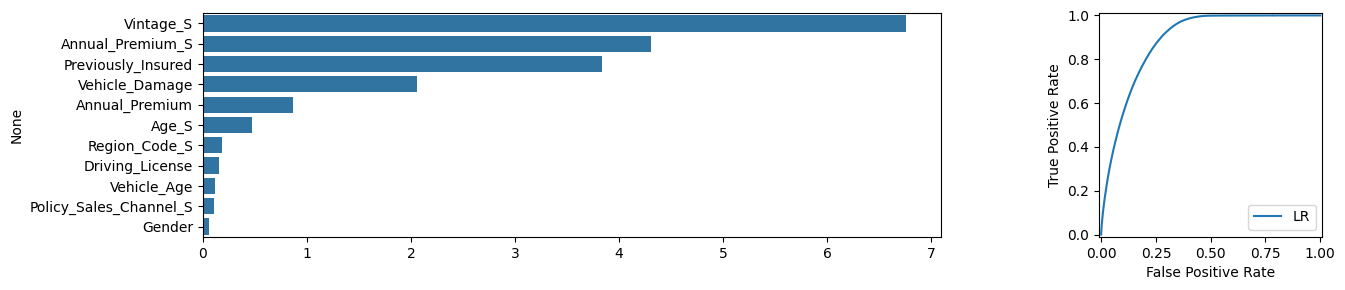

[0.8844378352970192]

In [266]:
from sklearn.metrics import RocCurveDisplay, roc_curve
s_coef = pd.Series(
    result['model_result'][0]['model'].coef_[0],
    index=result['model_result'][0]['variables']
)
s_vars = s_coef.index.to_series().str.split('__').map(lambda x: x[1]).str.split('_').apply(
    lambda x: '_'.join(x[:[i for i in range(len(x), 0, -1) if '_'.join(x[:i]) in pd_procs.df_var.index][0]])
)
fig, axes = plt.subplots(1, 2, figsize=(16, 3))
s_coef.abs().groupby(s_vars).mean().sort_values(ascending=False).pipe(lambda x: sns.barplot(y=x.index, x=x.values, ax=axes[0]))
fpr, tpr, _ = roc_curve(df_train.loc[result['valid_prd'].index, target], result['valid_prd'])
RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name='LR').plot(ax=axes[1])
plt.tight_layout()
plt.show()
result['valid_scores']

In [118]:
comb_cat_list = [
    ('VA', ['Vehicle_Damage', 'Annual_Premium_c']),
    ('VAge', ['Vehicle_Damage', 'Age_c']),
    ('PA', ['Previously_Insured', 'Annual_Premium_c']),
    ('VV', ['Vehicle_Damage', 'Vintage_c']),
    ('PAge', ['Previously_Insured', 'Age_c']),
    ('VP', ['Vehicle_Damage', 'Policy_Sales_Channel']),
    ('PVc', ['Previously_Insured', 'Vintage_c']),
    ('PP', ['Previously_Insured', 'Policy_Sales_Channel']),
    ('RV', ['Region_Code', 'Vehicle_Damage']),
    ('V2V', ['Vehicle_Age', 'Vehicle_Damage']),
    ('RP', ['Region_Code', 'Previously_Insured']),
    ('PV2', ['Previously_Insured', 'Vehicle_Age']),
    ('PV', ['Previously_Insured', 'Vehicle_Damage']),
    ('GV2', ['Gender', 'Vehicle_Damage']),
    ('GP', ['Gender', 'Previously_Insured']),
    ('AA', ['Annual_Premium_c', 'Age_c']),
    ('AV', ['Annual_Premium_c', 'Vintage_c']),
    ('VPAV', ['Vehicle_Damage', 'Previously_Insured', 'Age_c', 'Vintage_c']),
    ('VPPV', ['Vehicle_Damage', 'Previously_Insured', 'Policy_Sales_Channel', 'Vintage_c']),
    ('VPPA', ['Vehicle_Damage', 'Previously_Insured', 'Policy_Sales_Channel', 'Age_c']),
    ('VPVGAP', ['Vehicle_Damage', 'Previously_Insured', 'Vehicle_Age', 'Gender', 'Age_c', 'Policy_Sales_Channel']),
    ('VPVGAV', ['Vehicle_Damage', 'Previously_Insured', 'Vehicle_Age', 'Gender', 'Age_c', 'Vintage_c']),
    ('VPVGAR', ['Vehicle_Damage', 'Previously_Insured', 'Vehicle_Age', 'Gender', 'Age_c', 'Region_Code']),
    ('VPRV', ['Vehicle_Damage', 'Previously_Insured', 'Region_Code', 'Vintage_c']),
    ('VPVA', ['Vehicle_Damage', 'Previously_Insured', 'Vehicle_Age', 'Annual_Premium_c']),
    ('VPPAc', ['Vehicle_Damage', 'Previously_Insured', 'Policy_Sales_Channel', 'Annual_Premium_c']),
    ('VPRAc', ['Vehicle_Damage', 'Previously_Insured', 'Region_Code', 'Annual_Premium_c']),
]
"""comb_var_list = list()
for n, vars in comb_cat_list:
    df_train[n] = dproc.combine_cat(df_train[vars], '_')
    comb_var_list.append(('combine_categories', df_train[n], ', '.join(vars) + ' were combined', 'Categorical'))

df_var = pd.concat([
    df_var, 
    dproc.get_type_vars(comb_var_list)
], axis=0)

df_train.to_pickle(files['train_pkl'])
del df_train"""
''

''

In [119]:
df_var

,Description,src,min,max,na,count,n_unique,dtype,f32,i32,i16,i8
id,NaN,NaN,NaN,NaN,0.0,0.0,0.0,Int32,False,False,False,False
Gender,NaN,NaN,NaN,NaN,0.0,0.0,0.0,Categorical(ordering='physical'),False,False,False,False
Age,NaN,NaN,NaN,NaN,0.0,0.0,0.0,Int8,False,False,False,False
Driving_License,NaN,NaN,NaN,NaN,0.0,0.0,0.0,Int8,False,False,False,False
Region_Code,NaN,NaN,NaN,NaN,0.0,0.0,0.0,Categorical(ordering='physical'),False,False,False,False
Previously_Insured,NaN,NaN,NaN,NaN,0.0,0.0,0.0,Categorical(ordering='physical'),False,False,False,False
Vehicle_Age,NaN,NaN,NaN,NaN,0.0,0.0,0.0,Categorical(ordering='physical'),False,False,False,False
Vehicle_Damage,NaN,NaN,NaN,NaN,0.0,0.0,0.0,Categorical(ordering='physical'),False,False,False,False
Annual_Premium,NaN,NaN,NaN,NaN,0.0,0.0,0.0,Float32,False,False,False,False
Policy_Sales_Channel,NaN,NaN,NaN,NaN,0.0,0.0,0.0,Categorical(ordering='physical'),False,False,False,False
